In [26]:
from math import radians, cos, sin, asin, sqrt,floor,ceil
import pandas as pd
import numpy as np
import sys
import os
import pymysql
from sqlalchemy import create_engine
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt

In [27]:
#计算两点间距离-m
def geodistance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    dis=2*asin(sqrt(a))*6371*1000
    return dis

In [28]:
#向下保留2位小数
def remain_points(num):
        num_x , num_y = str(num).split('.')
        num = float(num_x+'.'+num_y[0:2])       
        return num 

In [29]:
geodistance(121.44,31.22,121.54,31.22)

9509.20502436699

In [30]:
df=pd.read_excel('刷单识别new.xlsx')

In [31]:
df['经度']=df['经度'].apply(lambda x:remain_points(x))
df['纬度']=df['纬度'].apply(lambda x:remain_points(x))

In [32]:
df.head()

,司机id,司机手机,用户手机,用户id,经度,纬度,精确经度,精确纬度,订单时间,是否司机号
0,101,15807554270,18355519765,97253,120.10,30.29,120.109320,30.293509,2018-08-03 16:27:30,1
1,101,15807554270,13866665531,110411,121.24,31.03,121.241913,31.035725,2018-08-04 18:36:46,1
2,101,15807554270,13866664137,113237,121.70,31.07,121.708560,31.070751,2018-08-07 11:11:01,1
3,101,15807554270,18368864280,97269,120.10,30.29,120.109497,30.293535,2018-08-07 17:15:08,1
4,101,15807554270,13866668032,115138,116.34,39.98,116.349243,39.986588,2018-08-08 15:03:01,0


In [33]:
df['位置']=df.经度.astype('str')+'|'+df.纬度.astype('str')

In [34]:
df['是否刷单号']=0

In [35]:
df_value_counts=df.groupby('司机id').apply(lambda x:x.位置.value_counts()).reset_index()

In [36]:
#同一位置刷单判断
df_same_place=df_value_counts[(df_value_counts['位置']>=4)&(df_value_counts.level_1!='0.0|0.0')]

In [37]:
df_same_place.rename(columns={'level_1':'位置','位置':'次数'},inplace=True)

D:\software\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [38]:
df_same_place=df_same_place.reset_index(drop=True)

In [39]:
#计算是否上海市
df['是否外地']=0
df.loc[((df.经度<120.51)|(df.经度>122.12)|(df.纬度<30.40)|(df.纬度>31.53))&df.经度!=0,'是否外地']=1

In [40]:
#连接订单表和司机同一位置统计表
order_sp_info=df.merge(df_same_place,on=['司机id','位置'])

In [41]:
#计算同位置司机订单间隔
order_sp_interval=order_sp_info.groupby(['司机id','位置']).apply(lambda x:((x.订单时间-x.订单时间.shift())/timedelta(hours=1)).mean()).reset_index()

In [42]:
order_sp_interval.rename(columns={0:'间隔'},inplace=True)

In [43]:
df_same_place['间隔']=order_sp_interval.间隔

In [44]:
#判断司机同一地点订单是否刷单
df_sp_driver=df_same_place[(df_same_place.次数>=3)|(df_same_place.间隔>1)]

In [45]:
df_sp_driver.loc[:,'是否同地点刷单']=1
df_sp_driver.drop(['次数','间隔'],axis=1,inplace=True)

In [46]:
df=df.merge(df_sp_driver,how='left',on=['司机id','位置']).fillna(0)

In [47]:
#提取订单时间精确到小时
df['订单小时']=df.订单时间.apply(lambda x:x.strftime('%Y-%m-%d %H'))

In [48]:
#筛选同小时有两单以上的司机
driver_order_sh=df[df.经度>0].groupby(['司机id','订单小时']).位置.count().reset_index()

In [67]:
#计算同小时超过3单的时段和司机
driver_3order_sh=df.groupby(['司机id','订单小时']).位置.count().reset_index()
driver_3order_sh.loc[driver_3order_sh.位置>=3,'是否同时段刷单']=1
driver_3order_sh=driver_3order_sh.loc[driver_3order_sh.是否同时段刷单==1].drop('位置',axis=1)

In [54]:
df_2order_sh=df.merge(driver_order_sh.loc[driver_order_sh.位置>=2,['司机id','订单小时']],on=['司机id','订单小时'])

In [55]:
#经纬度下移并赋值
df_2order_sh['经度下移']=df_2order_sh.groupby(['司机id','订单小时']).apply(lambda x:x.精确经度.shift()).reset_index().精确经度
df_2order_sh['纬度下移']=df_2order_sh.groupby(['司机id','订单小时']).apply(lambda x:x.精确纬度.shift()).reset_index().精确纬度

In [56]:
#计算订单时间差
df_2order_sh['时间间隔']=df_2order_sh.groupby(['司机id','订单小时']).apply(lambda x:(x.订单时间-x.订单时间.shift())/timedelta(hours=1)).reset_index().订单时间

In [57]:
#将无时间间隔的赋予极小间隔
df_2order_sh.loc[df_2order_sh.时间间隔==0,'时间间隔']=0.0001

In [58]:
df_2order_sh_js=df_2order_sh[(~df_2order_sh.时间间隔.isna())&(df_2order_sh.经度!=0)&(df_2order_sh.经度下移!=0)].reset_index(drop=True)
df_2order_sh_js['时速']=df_2order_sh_js.apply(lambda x:round(geodistance(x.精确经度,x.精确纬度,x.经度下移,x.纬度下移)/1000/x.时间间隔),axis=1)

In [62]:
driver_3order_sh.head()

,司机id,订单小时,是否同时段刷单
58,119001,2018-08-22 14,1.0
99,122320,2018-08-02 12,1.0
106,122320,2018-08-03 18,1.0
119,122320,2018-08-20 15,1.0
177,122354,2018-08-04 14,1.0


In [71]:
#筛选相近时间不同地点刷单
df_final=df.merge(driver_3order_sh,on=['司机id','订单小时'],how='left').\
merge(df_2order_sh_js.loc[df_2order_sh_js.时速>=80,['用户id','时间间隔','时速']],on='用户id',how='left')

In [72]:
df_final.to_excel('shuadan2.xlsx')

In [120]:
df_new=pd.read_excel('shuadan1.xlsx')

In [121]:
df_new.head()

,司机id,司机手机,用户手机,用户id,经度,纬度,精确经度,精确纬度,订单时间,是否司机号,位置,是否刷单号,是否外地,是否同地点刷单,其他规则,订单小时,时间间隔,时速
0,101,15807554270,18355519765,97253,120.10,30.29,120.109320,30.293509,2018-08-03 16:27:30,1,120.1|30.29,0,1,1,0,2018-08-03 16,NaN,NaN
1,101,15807554270,13866665531,110411,121.24,31.03,121.241913,31.035725,2018-08-04 18:36:46,1,121.24|31.03,0,0,0,0,2018-08-04 18,NaN,NaN
2,101,15807554270,13866664137,113237,121.70,31.07,121.708560,31.070751,2018-08-07 11:11:01,1,121.7|31.07,0,0,0,0,2018-08-07 11,NaN,NaN
3,101,15807554270,18368864280,97269,120.10,30.29,120.109497,30.293535,2018-08-07 17:15:08,1,120.1|30.29,0,1,1,0,2018-08-07 17,NaN,NaN
4,101,15807554270,13866668032,115138,116.34,39.98,116.349243,39.986588,2018-08-08 15:03:01,0,116.34|39.98,0,1,0,0,2018-08-08 15,NaN,NaN


In [125]:
df_new.loc[(df_new.是否外地==1)|(df_new.是否同地点刷单==1)|(df_new.其他规则==1)|(df_new.司机id==101),'是否刷单号']=1

In [127]:
df_new.to_excel('shuadanend.xlsx')

In [2]:
real_df=pd.read_excel('流量司机物料更换对比.xlsx')

In [3]:
real_df.head()

,司机id,姓名,手机,激活时间,激活状态,装车总时长,活跃天数(任务),活跃天数(领券),活跃天数占比,累计完成任务数,累计领券数,完成任务数,领券数,转化率,在线日均完成任务数,在线日均领券数,物料批次
0,122320,张健,15072011065,2018-08-01,1,19,3,2,0.157895,6.0,2.0,0.315789,0.105263,0.3333,2.000000,0.666667,1
1,122338,蔡杰阳,18116262922,2018-08-01,1,19,6,3,0.315789,9.0,4.0,0.473684,0.210526,0.4444,1.500000,0.666667,1
2,122322,许玉华,18301932289,2018-08-01,1,19,5,3,0.263158,6.0,3.0,0.315789,0.157895,0.5000,1.200000,0.600000,1
3,122353,孔宪明,13304280488,2018-08-02,1,18,15,10,0.833333,27.0,14.0,1.500000,0.777778,0.5185,1.800000,0.933333,1
4,122354,卢卫生,13689900885,2018-08-02,1,18,17,15,0.944444,92.0,41.0,5.111111,2.277778,0.4457,5.411765,2.411765,1


In [18]:
real_df.loc[(real_df.物料批次==1)&(real_df.完成任务数==0)]

,司机id,姓名,手机,激活时间,激活状态,装车总时长,活跃天数(任务),活跃天数(领券),活跃天数占比,累计完成任务数,累计领券数,完成任务数,领券数,转化率,在线日均完成任务数,在线日均领券数,物料批次
30,122490,甄玉飞,15237402535,2018-08-04,1,16,0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1
57,122557,朱海军,18762100513,2018-08-06,1,15,0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1
59,122581,江国成,19945733218,2018-08-06,1,15,0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1
74,122719,杨磊,17502131878,2018-08-10,1,11,0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1
87,121626,钱健,17502105626,2018-08-18,-2,4,0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1


In [58]:
pd.cut(dd,bins=2)

0    (-0.003, 1.5]
1    (-0.003, 1.5]
2    (-0.003, 1.5]
3       (1.5, 3.0]
4    (-0.003, 1.5]
5       (1.5, 3.0]
6       (1.5, 3.0]
dtype: category
Categories (2, interval[float64]): [(-0.003, 1.5] < (1.5, 3.0]]

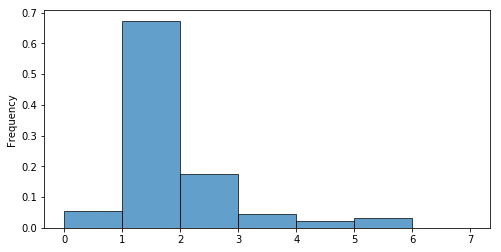

In [60]:
real_df.loc[real_df.物料批次==1,'在线日均完成任务数'].plot.hist(bins=range(0,8),density=True,alpha=0.7,figsize=(8,4),edgecolor='black')
plt.show()

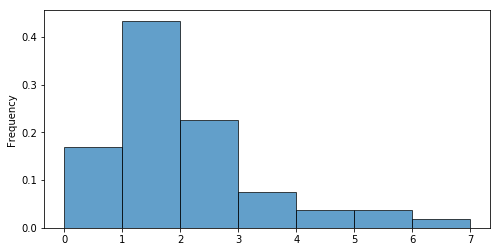

In [62]:
real_df.loc[real_df.物料批次==2,'在线日均完成任务数'].plot.hist(bins=range(0,8),density=True,alpha=0.7,figsize=(8,4),edgecolor='black')
plt.show()

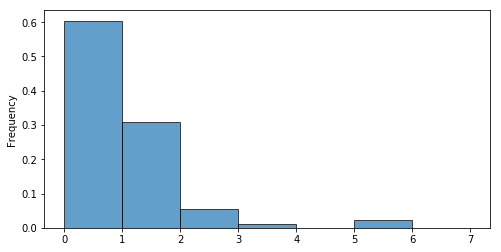

In [59]:
real_df.loc[real_df.物料批次==1,'完成任务数'].plot.hist(bins=range(0,8),density=True,alpha=0.7,figsize=(8,4),edgecolor='black')
plt.show()

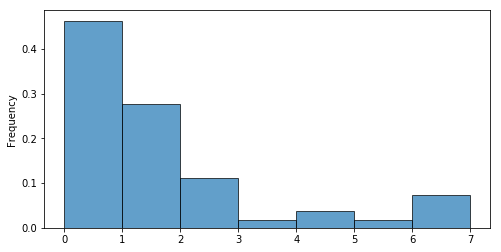

In [61]:
real_df.loc[real_df.物料批次==2,'完成任务数'].plot.hist(bins=range(0,8),density=True,alpha=0.7,figsize=(8,4),edgecolor='black')
plt.show()